# Titanic ML Model to Predict Survival

Below I will walk through my process of building a machine learning model to predict the survival of passengers aboard the Titanic. Please let me know if you have any suggestions on how to improve my model, or any questions about my work. Thanks for stopping by!

*  [Importing data](#chapter1) 
*  [Feature Engineering](#chapter2) 
    * [Extracting Title from Passenger Name](#section_2_1) 
    * [Creating Women & Child Groups](#section_2_2) 
    * [Party Size](#section_2_3) 
    * [Fare Per Passenger](#section_2_4)  
    * [Creating Age Categories](#section_2_5)   
*  [Dealing with Missing Values](#chapter3) 
    * [Missing values for 'Fare'](#section_3_1) 
    * [Missing values for 'Embarked'](#section_3_2) 
    * [Missing values for 'Cabin'](#section_3_3) 
    * [Missing values for 'Age'](#section_3_4) 
*  [Data Visualization](#chapter4) 
* [Building a Model to Predict Survival](#chapter5) 
    * [Testing Multiple Models](#section_5_1) 
    * [Gradient Boosting Classifier](#section_5_2) 
    * [Support Vector Machine](#section_5_3) 
*  [Final Predictions](#chapter6) 

# 1. Importing Data <a class="anchor"  id="chapter1"></a>


In [1]:
# Importing standard libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# Importing and combining data, taking preliminary look 
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# Combining data
combined = pd.concat([train, test], axis=0, ignore_index=True)

# Checking data types
display(combined.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


The training set has 891 instances, the test set has 418 instances, and the combined has 1309. 

# 2. Feature Engineering  <a class="anchor"  id="chapter2"></a>

Our dataset already comes with many features, including Passenger Class, Sex, Age, Embarked Port, etc. In data analysis, it's important to be able to read between the lines in the data and extract other features that might help determine a passenger's survival. 

## 2.1 Extracting Title from Passenger Name<a class="anchor"  id="section_2_1"></a>

It looks like many of the passengers have associated titles in their names, such as "Miss.", "Mrs.", etc. Title could give us good insight into a passenger's age, marital status, gender, and social status, all of which could help predict a passenger's survival.
We can use regular expressions to extract passenger titles from their names.


In [2]:
# Importing regular expressions 
import re

# Extract names column from dataset
names = combined['Name']

# Regular expression that will extract a capital letter followed by lowercase letters and a period
title_pattern = re.compile(r'\b[A-Za-z]+\.')

# Extract titles from names
titles = []
for name in names:
    match = title_pattern.search(name)
    if match:
        titles.append(match.group())
        
# Add titles to new column in dataframe
combined['Title'] = titles

# Looking at the distribution of titles 
display(combined['Title'].value_counts())
display(combined['Title'].count())

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Mlle.          2
Major.         2
Ms.            2
Lady.          1
Sir.           1
Mme.           1
Don.           1
Capt.          1
Countess.      1
Jonkheer.      1
Dona.          1
Name: Title, dtype: int64

1309

It looks like every passenger has an associated title! Some are more common, such as "Mr." and "Miss.", while others such as "Major." and "Rev." have less than ten instances. Since our model is not going to learn anything interesting from a title with very few associated passengers, I will put these titles into a new group called 'Uncommon'. 

Before doing so, it appears that some of the uncommon titles can be recategorized into more common titles. 

Mlle. is a French title for an unmarried woman -> group into Miss.

Mme. is French title for a married woman -> group into Mrs.

Don. and Dona. can also be used as the Spanish forms of Mr. and Mrs., but often times they have more of an honorific meaning which could signify higher status. For this reason, I will not group these into Mr. and Mrs. 

There are also two passengers with the title "Ms." instead of "Miss.". According to [Scribbr](https://www.scribbr.com/effective-communication/ms-mrs-miss/#:~:text=Miss%20is%20the%20form%20always,are%20unsure%20how%20to%20address.), "*Miss is a title used for an unmarried woman... mainly for young women and girls (roughly up to the age of 30)*", while "*Ms. is generally used for unmarried women past the age of 30.*"

Upon doing some research on the title "Master.", I found the following: "*After its replacement in common speech by Mister, Master was retained as a form of address only for boys who had not yet entered society. By the late 19th century, etiquette dictated that men be addressed as Mister, and boys as Master.*" Because Master is being used here to refer to boys under the age of 18, let's plot the distribution for "Miss." and "Master." to make sure that it is not only for girls under the age of 18. 


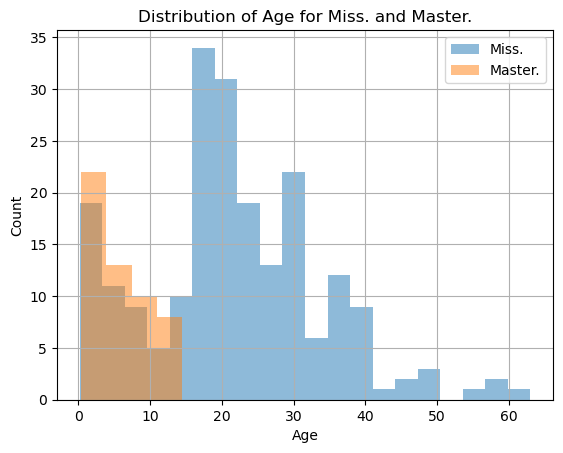

In [3]:
combined[combined['Title']=='Miss.']['Age'].dropna().hist(alpha=0.5, bins=20, label='Miss.')
combined[combined['Title']=='Master.']['Age'].dropna().hist(alpha=0.5, bins=4, label='Master.')

plt.title('Distribution of Age for Miss. and Master.')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

While the title "Master." is only for boys, the age distribution for "Miss." seems to span from girls at a very young age, all the way to women in their mid 60s. It seems that it was used as a way to signify both age (for girls) and marital status (for adult women). 

For this reason, it is appropriate to group "Ms." and "Mlle." into "Miss.". 

In [4]:
# Recategorize uncommon titles that fit into "Miss." and "Mrs."
combined.loc[combined['Title'].isin(['Ms.', 'Mlle.']), 'Title'] = 'Miss.'
combined.loc[combined['Title'].isin(['Mme.']), 'Title'] = 'Mrs.'

# Create new title 'Uncommon'
uncommon_titles = ['Major.', 'Lady.', 'Sir.', 'Don.', 'Capt.', 'Countess.', 'Jonkheer.', 'Dona.', 'Dr.', 'Rev.', 'Col.']
combined.loc[combined['Title'].isin(uncommon_titles), 'Title'] = 'Uncommon'

# Display count of each title 
display(combined['Title'].value_counts())

Mr.         757
Miss.       264
Mrs.        198
Master.      61
Uncommon     29
Name: Title, dtype: int64

## 2.2 Creating Women & Children Groupss <a class="anchor"  id="section_2_2"></a>

During my research for this kernel on The Titanic disaster, I found many sources stating that women & children were put on to rescue boats first, while men had to stand by. Apparently this was [a common code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first) in the 19th and 20th centuries in Britain during maritime disasters. Taking this theory one step further  leads to the assumption that if a family of women & children were indeed rescued, they would likely all be put on the same rescue boat together. Thus evolved the "Woman-Child-Group" theory, which states that groups of women & children from the same family either all live together or all die together, while adult men die almost without exception. I owe the credit for this theory to [Chris Deotte's kernel](https://www.kaggle.com/code/cdeotte/titanic-using-name-only-0-81818), which is just brilliant!

In accordance with this theory, I want to extract the following features from our dataset: 
* 'In_WCG': 1 if passenger is a woman or a child in a Woman-Child-Group, 0 otherwise 
* 'WCG_survived': 1 if the passenger is in a WCG, and of the people in the same WCG for whom we have 'Survived' data, the survival rate is greater than 50%; 0 otherwise 
* 'WCG_not_survived': 1 if the passenger is in a WCG, and of the people in the same WCG for whom we have 'Survived data, the survival rate is less than 50%; 0 otherwise

We can use last name in this dataset as a way to identify the passengers that were traveling together as a family. 

One thing to note is that the WCG feature extraction assumes that all passengers on *The Titanic* who shared the same last name were related, which I don't believe is necessarily true. There could be common last names that were shared between unrelated passengers. However, for the sake of our analysis, I will be using last name as a way to group families, and sort by gender and title to find Woman-Child-Groups.

In [5]:
def extract_last_name(name):
    # Split the name string on the comma character
    name_parts = name.split(',')
    # The last name is the first part of the resulting list
    last_name = name_parts[0]
    # Remove any leading or trailing whitespace
    last_name = last_name.strip()
    return last_name

# Apply the function to the 'Name' column of the DataFrame to create a new 'Last Name' column
combined['Last_name'] = combined['Name'].apply(extract_last_name)

# Creating column that only contains last names for groups with women & children
combined['Last_name_WCG'] = combined['Last_name']

# Filtering out adult males
combined.loc[((combined['Sex'] == 'male') & (combined['Title'] == 'Mr.'))|
             ((combined['Sex'] == 'male') & (combined['Title'] == 'Uncommon')), 'Last_name_WCG'] = np.nan

# Creating WCG_size variable that counts the number of passengers in a given women-child group
combined['WCG_size'] = combined.groupby('Last_name_WCG')['Last_name_WCG'].transform('count')
combined.loc[(combined['WCG_size'] < 2.0 ), 'Last_name_WCG'] = np.nan
combined.loc[(combined['WCG_size'] >= 2.0), 'In_WCG'] = 1
combined.loc[(combined['WCG_size'] < 2.0 ), 'In_WCG'] = 0

# Creating variables WCG_survived and WCG_not_survived to indicate known probability of survival in a given women-child group
for name in combined['Last_name_WCG'].unique():
    survival_rate = np.mean(combined[combined['Last_name_WCG']==name]['Survived'])
    if survival_rate > 0.5:
        combined.loc[combined['Last_name_WCG']==name, 'WCG_survived'] = 1
    else:
        combined.loc[combined['Last_name_WCG']==name, 'WCG_not_survived'] = 1
        
combined[['In_WCG', 'WCG_survived', 'WCG_not_survived']] = combined[['In_WCG', 'WCG_survived', 'WCG_not_survived']].fillna(0)

# Dropping 'Name', Last_name', 'Last_name_WCG', and 'WCG_size' as they are not relevant to my analysis
combined = combined.drop(columns=['Name', 'Last_name', 'Last_name_WCG', 'WCG_size'])

## 2.3 Party Size <a class="anchor"  id="section_2_3"></a>

There seem to be many people aboard *The Titanic* who were traveling with others. The total number of people that a passenger was traveling with might be a good predictor of their survival. A solo traveler might look out their own interests more than someone who ia traveling with siblings, parents, or even friends. 

We can infer a passenger's family size by using the variables 'SibSp' and 'Parch', but what about the passengers who were traveling with friends or others, such as a nanny or assistant? It appears that passengers who booked under the same reservation share the same ticket number. We can use a passenger's family size or the number of other passengers they share a ticket number with to determine how many people they were traveling with.

In [6]:
# Create variable 'Family_size' using 'SibSp' and 'Parch'
combined['Family_size'] = combined['SibSp'] + combined['Parch'] + 1

# Compare 'Party_size' to a value that counts the number of parties on a unique ticket 
# as some families seemed to have the same ticket number
display(combined['Ticket'].value_counts())

# Ticket only has 929 unique values, which means that 380 passengers were sharing a ticket
# with at least one other person, we can create a variable the counts this
combined['Ticket_group_size'] = combined.groupby('Ticket')['Ticket'].transform('count')

# Check in how many instances 'Family_size' and 'Ticket_group_size' are equal
display(combined[combined['Family_size']==combined['Ticket_group_size']])

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: Ticket, Length: 929, dtype: int64

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,In_WCG,WCG_not_survived,WCG_survived,Family_size,Ticket_group_size
1,2,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,0.0,0.0,0.0,2,2
2,3,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,0.0,0.0,0.0,1,1
3,4,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.,0.0,0.0,0.0,2,2
4,5,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr.,0.0,0.0,0.0,1,1
5,6,0.0,3,male,NaN,0,0,330877,8.4583,NaN,Q,Mr.,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1304,NaN,3,female,28.0,0,0,347086,7.7750,NaN,S,Miss.,0.0,0.0,0.0,1,1
1304,1305,NaN,3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr.,0.0,0.0,0.0,1,1
1306,1307,NaN,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr.,0.0,0.0,0.0,1,1
1307,1308,NaN,3,male,NaN,0,0,359309,8.0500,NaN,S,Mr.,0.0,0.0,0.0,1,1


It looks like family size and ticket group size match in 1025 instances out of 1309. That means the other 284 instances are mismatched somehow. Let's take a look at those instances to see what might be going on. 

In [7]:
mismatched = combined[combined['Family_size']!=combined['Ticket_group_size']]
display(len(mismatched[mismatched['Family_size']>mismatched['Ticket_group_size']]))
display(len(mismatched[mismatched['Family_size']<mismatched['Ticket_group_size']]))

84

200

Out of the 284 passengers where 'Family_size' and 'Ticket_group_size' are mismatched, there are 84 passengers where 'Family_size' is greater than 'Ticket_group_size', and 200 passengers where 'Ticket_group_size' is greater than 'Family_size'. 
* A family size that is greater than the ticket group size tells us that the passenger was traveling with family, but did not share a ticket ID with them. They could have booked separately at different ticket offices or boarded from different ports altogether. 
* A ticket group size that is greater than family size tells us that the passenger was likely traveling with someone that they were not related to, or did not fall under the definition of family according to the 'SibSp' and 'Parch' variables. A reminder that 'SibSp' (siblings and spouses) and 'Parch' (parents and children) are defined as follows:
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)
    * Parent = mother, father 
    * Child = daughter, son, stepdaughter, stepson (does not include nannies)

To create a finalized variable that shows the number of people a passenger was traveling with, I will take the larger of 'Family_size' and 'Ticket_group_size' for each passenger in the dataset. I will also create a binary variable 'Is_alone' to identify those who were traveling completely alone.

In [8]:
combined['Party_size'] = combined[['Family_size', 'Ticket_group_size']].max(axis=1)

combined['Is_alone'] = combined['Party_size'].apply(lambda x: 1 if x == 1 else 0)

# Drop 'Ticket' as it is not useful to my analysis
combined = combined.drop(columns='Ticket')

## 2.4 Fare Per Passenger <a class="anchor"  id="section_2_4"></a>

Let's take a look at the distribution of 'Fare' for each Pclass. 

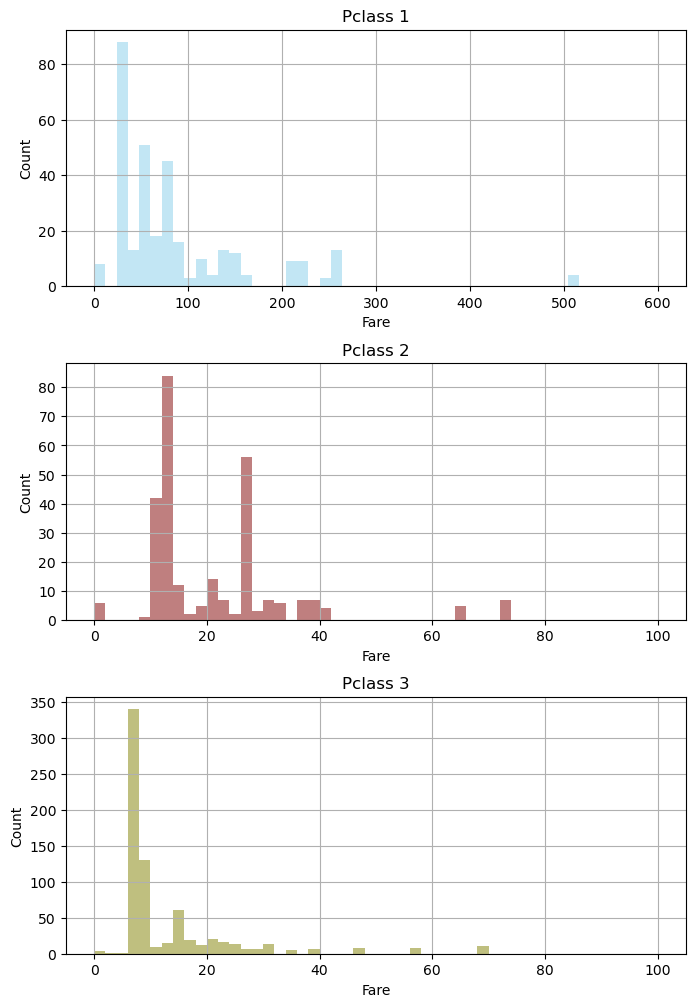

In [9]:
# Let's take a look at the distribution of 'Fare' for each Pclass

# Create a figure and axis object using subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    
# Pclass == 1
combined[combined['Pclass'] == 1]['Fare'].hist(alpha=0.5, ax=axs[0], bins=50, range=(0,600), color='skyblue')
axs[0].set_title('Pclass 1')
axs[0].set_xlabel('Fare')
axs[0].set_ylabel('Count')

# Pclass == 2
combined[combined['Pclass'] == 2]['Fare'].hist(alpha=0.5, ax=axs[1], bins=50, range=(0,100), color='maroon')
axs[1].set_title('Pclass 2')
axs[1].set_xlabel('Fare')
axs[1].set_ylabel('Count')

# Pclass == 2
combined[combined['Pclass'] == 3]['Fare'].hist(alpha=0.5, ax=axs[2], bins=50, range=(0,100), color='olive')
axs[2].set_title('Pclass 3')
axs[2].set_xlabel('Fare')
axs[2].set_ylabel('Count')
    
# Show the plot
plt.subplots_adjust(hspace=0.3)
plt.show()

There are quite a few outliers for each Pclass' fare distribution. Upon inspecting the data, all of the outliers are passengers who were traveling with multiple people under the same ticket reservation, i.e. they had a large 'Ticket_group_size'. It appears that the 'Fare' values are summed for passengers who had multiple people under the same ticket. In order to calculate fare per passenger, we can take 'Fare' and divide it by 'Ticket_group_size', which is already defined as the number of people sharing the same unique ticket number. Then, let's take a look at the distributions again and see if the outliers have resolved.

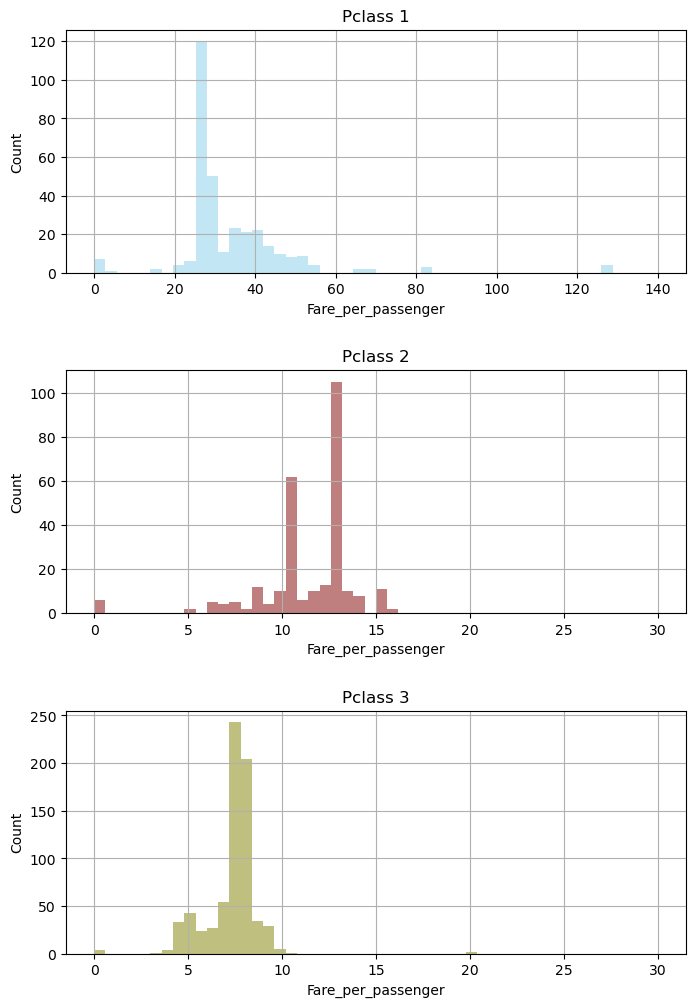

In [10]:
combined['Fare_per_passenger'] = combined['Fare'] / combined['Ticket_group_size']
         
# Create a figure and axis object using subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))

# Pclass == 1
combined[combined['Pclass'] == 1]['Fare_per_passenger'].hist(alpha=0.5, ax=axs[0], bins=50, range=(0,140), color='skyblue')
axs[0].set_title('Pclass 1')
axs[0].set_xlabel('Fare_per_passenger')
axs[0].set_ylabel('Count')

# Pclass == 2
combined[combined['Pclass'] == 2]['Fare_per_passenger'].hist(alpha=0.5, ax=axs[1], bins=50, range=(0,30), color='maroon')
axs[1].set_title('Pclass 2')
axs[1].set_xlabel('Fare_per_passenger')
axs[1].set_ylabel('Count')

# Pclass == 3
combined[combined['Pclass'] == 3]['Fare_per_passenger'].hist(alpha=0.5, ax=axs[2], bins=50, range=(0,30),  color='olive')
axs[2].set_title('Pclass 3')
axs[2].set_xlabel('Fare_per_passenger')
axs[2].set_ylabel('Count')

# Show the plot
plt.subplots_adjust(hspace=0.4)
plt.show()

Note that I have shrunk the x-axis ranges for the above graphs considerably, and the distributions are looking a lot less spread out. Looks like the creation of 'Fare_per_passenger' was able to resolve a lot of the outliers. We will use 'Fare_per_passenger' going forward in our analysis instead of 'Fare'.

In [11]:
combined = combined.drop(columns='Fare')

## 2.5 Creating Age Categories <a class="anchor"  id="section_2_5"></a>


If women and children were rescued first, I would assume that age is an important factor in survival, with children having higher survival rates than adults. There are over 250 missing values for 'Age' which I will impute later, but for now I will create 4 categories for 'Age' using KMeans Clustering. 

While I could keep 'Age' a continuous variable, I think it's more important that we are able to identify the youngest passengers and oldest passengers in discrete categories, as these passengers likely had higher survival rates. Let's take a look.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[13.44266554 27.83678908 43.53928809]


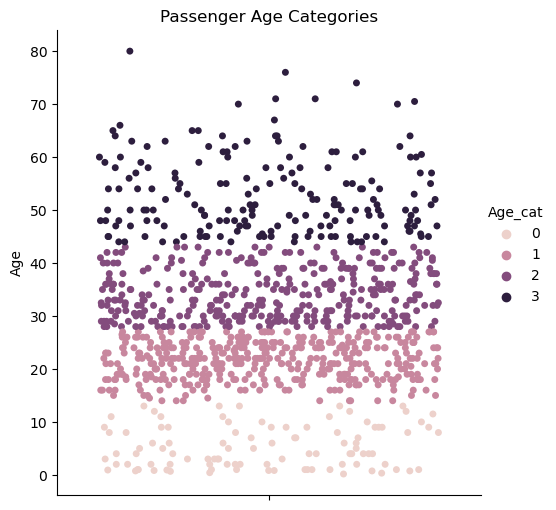

In [12]:
from sklearn.cluster import KMeans

# Splitting combined dataset based on missing 'Age' values
test_age = combined[combined['Age'].isna()]
train_age = combined[combined['Age'].notnull()]

# Fitting the KMeans clustering algorithm 
kmeans = KMeans(n_clusters=4, random_state=41)
labels = kmeans.fit_predict(train_age['Age'].to_numpy().reshape(-1,1))

# Define a mapping dictionary to relabel the clusters, 0 for youngest to 3 for oldest cluster
mapping = {label: i for i, label in enumerate(np.argsort(kmeans.cluster_centers_.flatten()))}
labels = [mapping[label] for label in labels]
train_age['Age_cat'] = labels

# Visualizing new age clusters
sns.catplot(y='Age', hue='Age_cat', data=train_age, jitter=0.4)
plt.title('Passenger Age Categories')

# Setting 'Age_cat' to missing for those with missing 'Age'
test_age['Age_cat'] = np.nan

# Combining back into full dataset
combined = pd.concat([train_age, test_age], axis=0)

# Finding age cutoffs for each cluster
centers = np.sort(kmeans.cluster_centers_.flatten())
cutoffs = (centers[:-1] + centers[1:]) / 2
print(cutoffs)

KMeans has created 4 clusters as follows: 
* 0 to 13.44 years
* 13.44 to 27.84 years
* 28.84 to 43.54 years
* 43.54 to 80 years

How do survival rates differ for these 4 clusters?

Age_cat
0    0.591549
1    0.372180
2    0.407115
3    0.370968
Name: 1.0, dtype: float64

Text(0, 0.5, 'Percent')

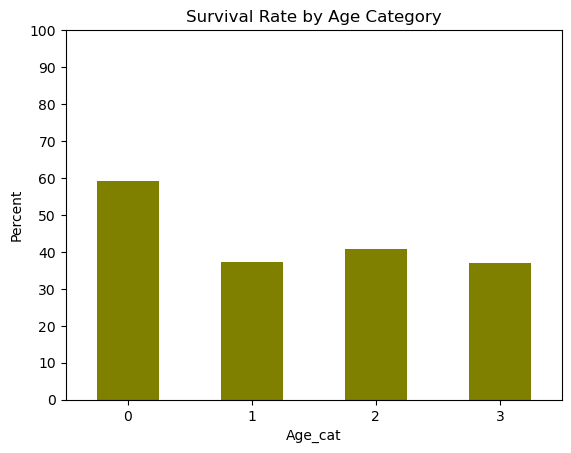

In [13]:
# Visualizing new age clusters
age_cat_survival = train_age.groupby(['Age_cat'])['Survived'].value_counts(normalize=True).unstack()
age_cat_survival = age_cat_survival[1]
display(age_cat_survival)
age_cat_survival.plot.bar(stacked=True, color=['olive'])
plt.title('Survival Rate by Age Category')
plt.xticks(rotation=360)
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
plt.ylabel('Percent')

Young children (under 13.44 years) had the best survival rate at 59.16%, while young adults (13.44 to 27.84 years) had the worst survival rate at 37.22%. This led me to wonder how these survival rates differ by gender. Let's take a look below.

Age_cat  Sex   
0        female    0.617647
         male      0.567568
1        female    0.747475
         male      0.149701
2        female    0.797753
         male      0.195122
3        female    0.794872
         male      0.176471
Name: 1.0, dtype: float64

Text(0, 0.5, 'Percent')

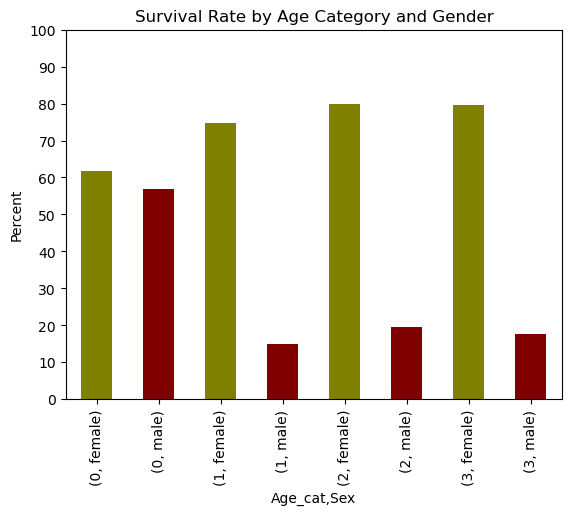

In [14]:
# Visualizing survival rates for each age cluster by gender
age_cat_survival = train_age.groupby(['Age_cat', 'Sex'])['Survived'].value_counts(normalize=True).unstack()
age_cat_survival = age_cat_survival[1]
display(age_cat_survival)
age_cat_survival.plot.bar(stacked=True, color=['olive', 'maroon'])
plt.title('Survival Rate by Age Category and Gender')
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
plt.ylabel('Percent')

It looks like males in the young adult age cluster were the least likely to get rescued. So if you were a male on *The Titanic*, what would get you rescued, other than being a boy under the age of 14? My first thought was money. Let's see if that is true...

Pclass
1    0.396040
2    0.151515
3    0.150198
Name: 1.0, dtype: float64

Text(0, 0.5, 'Percent')

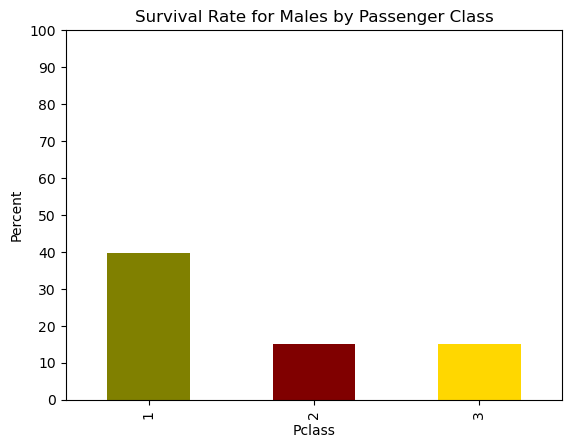

In [15]:
# Visualizing survival rates for each age cluster by class
males = train_age[train_age['Sex']=='male']
age_cat_survival = males.groupby(['Pclass'])['Survived'].value_counts(normalize=True).unstack()
age_cat_survival = age_cat_survival[1]
display(age_cat_survival)
age_cat_survival.plot.bar(stacked=True, color=['olive', 'maroon', 'gold'])
plt.title('Survival Rate for Males by Passenger Class')
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
plt.ylabel('Percent')

Looks like male passengers in first class were more likely to get rescued than passengers in second and third class, although the majority of male passengers across the board met the same tragic fate.

# 3. Dealing with Missing Values <a class="anchor"  id="chapter3"></a>
It looks like there are some missing values in the Age, Fare, Cabin, and Embarked columns. Note that the missing values in the Survived category are just from the test data set, which doesn't contain the output variable. I will deal with the missing values for the other columns below.

## 3.1 Missing values for 'Fare': <a class="anchor"  id="section_3_1"></a>

There is only 1 missing value for the 'Fare_per_passenger' feature. I will impute it using other features that are available to us for that instance and in the dataset.

In [16]:
# Looks like the observation that has'Fare_per_passenger' missing is for a passenger 
# that belonged to Pclass == 3 and was traveling alone
display(combined[combined['Fare_per_passenger'].isna()])

# As we saw earlier, families in the same Pclass paid a similar fare per passenger
display(combined.groupby('Pclass')['Fare_per_passenger'].describe())

# Find index for that observation
index = combined[combined['Fare_per_passenger'].isna()].index

# Impute'Fare_per_passenger' with mean of the 'Fare_per_passenger' column values for 'Pclass' equal to 3
combined.loc[index, 'Fare_per_passenger'] = combined[combined['Pclass'] == 3]['Fare_per_passenger'].mean()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Title,In_WCG,WCG_not_survived,WCG_survived,Family_size,Ticket_group_size,Party_size,Is_alone,Fare_per_passenger,Age_cat
1043,1044,NaN,3,male,60.5,0,0,NaN,S,Mr.,0.0,0.0,0.0,1,1,1,1,NaN,3.0


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,33.910500,15.369762,0.0,26.550000,29.70,38.64375,128.0823
2,277.0,11.411010,2.632930,0.0,10.500000,12.35,13.00000,16.0000
3,708.0,7.329146,1.471362,0.0,7.060031,7.75,7.92500,19.9667


## 3.2 Missing values for 'Embarked': <a class="anchor"  id="section_3_2"></a>

It looks like the only two missing values for 'Embarked' are for two women who were staying in the same cabin, B28. Their names were Icard, Miss. Amelie and Stone, Mrs. George Nelson (Martha Evelyn). A quick google search revealed that "*Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*" I will impute these missing values with 'S' for Southampton.

*Source: Encyclopedia Titanica*

In [17]:
# What were the names of the passengers with missing 'Embarked' values? 
display(combined[combined['Embarked'].isna()])

# Impute missing values for 'Embarked' with 'S' for Southampton
index = combined[combined['Embarked'].isna()].index
combined.loc[index, 'Embarked'] = 'S'

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Title,In_WCG,WCG_not_survived,WCG_survived,Family_size,Ticket_group_size,Party_size,Is_alone,Fare_per_passenger,Age_cat
61,62,1.0,1,female,38.0,0,0,B28,NaN,Miss.,0.0,0.0,0.0,1,2,2,0,40.0,2.0
829,830,1.0,1,female,62.0,0,0,B28,NaN,Mrs.,0.0,0.0,0.0,1,2,2,0,40.0,3.0


## 3.3 Missing values for 'Cabin': <a class="anchor"  id="section_3_3"></a>

There are 1014 missing observations in the 'Cabin' column. The information about the cabin each passenger was staying in would probably be extremely helpful if the data was complete. The cabin could indicate each passenger's location at the time of the collision, which happened at 11:40pm when most people would likely be in bed in their rooms. The location could further inform us as to each passenger's escape route, distance from the initial impact, and how far they were from the stern, which sank first.

I found some interesting information online saying the following: "*The allocation of cabins on the Titanic is a source of continuing interest and endless speculation. Apart from the recollections of survivors and a few tickets and boarding cards, the only authoritative source of cabin data is the incomplete first class passenger list recovered with the body of steward Herbert Cave.*" 

What this indicates is that the cabin data that is available to us is mostly for first class passengers. We know that first class passengers were on decks A-E, although decks D and E were also shared with second class. Let's confirm below whether most of the information we have is for first class passengers. 


In [18]:
combined['Deck'] = combined['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else None)

# What proportion of each deck were first class? 
display(combined.groupby('Pclass')['Deck'].count())
display(combined['Pclass'].value_counts())


Pclass
1    256
2     23
3     16
Name: Deck, dtype: int64

3    709
1    323
2    277
Name: Pclass, dtype: int64

We have cabin data for 295 passengers. Here's how that breaks down between passenger classes: 
- 256 are first class
- 23 are second class
- 16 are third class

In other words: 
- 79.26% of first class passengers have cabin data
- 8.30% of second class passengers have cabin data
- 2.26% of third class passengers have cabin data

While cabin data would be very valuable for this analysis, it underrepresents passengers in the second and third classes, and for this reason I decided to drop it altogether. I also considered creating a binary variable that indicates the presence or absence of cabin data for each passenger, but because there appears to be variety of ways the information was sourced (first class passenger list found with Herbert Cave, survivor accounts, and recovered bodies), I don't think its presence or absence will tell us anything particularly useful about a passenger's survival.

In [19]:
combined = combined.drop(columns=['Deck', 'Cabin'])

## 3.4 Missing values for 'Age': <a class="anchor"  id="section_3_4"></a>

While I could just impute the missing values for Age with the median age, I think I could do better by using the other features available in the dataset to take a more educated prediction. 

'Age_cat' is now a categorical variable, which means I will want to use ML algorithms that make categorical predictions, such as the following:
- Random Forest Classifier: an ensemble learning model that combines multiple decision trees to create a more accurate model, randomly selects a subset of features for each tree to prevent overfitting and improve accuracy 
- K-Nearest Neighbors: predicts categorical outcome by based on k-closest neighbors in the training set 
- Support Vector Machines (SVMs): a model that finds the best hyperplane to separate the data into different classes, and then predicts the target variable based on the position of the test point relative to the hyperplane
- Gradient Boosting Classifier: ensemble model that combines multiple weak learners, normally decision trees, to create a strong learned for classification problems 
- Decision Tree Classifier: tree-like model that splits data based on the feature that maximizes information gain or reduces impurity at each node 

I will test these models below, and then pick one to predict and impute the missing ages in the dataset.

In [20]:
# Import necessary libraries for building models
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

# Using get_dummies to create dummy variables for categorical features, dropping first category to avoid multicollinearity
combined_with_dummies = pd.get_dummies(combined, columns=['Title', 'Sex', 'Pclass', 'Embarked'], prefix=['Title', 'Sex', 'Pclass', 'Embarked'], drop_first=True)
combined = pd.concat([combined[['Title', 'Sex', 'Pclass', 'Embarked']], combined_with_dummies], axis=1)
display(combined.columns)

Index(['Title', 'Sex', 'Pclass', 'Embarked', 'PassengerId', 'Survived', 'Age',
       'SibSp', 'Parch', 'In_WCG', 'WCG_not_survived', 'WCG_survived',
       'Family_size', 'Ticket_group_size', 'Party_size', 'Is_alone',
       'Fare_per_passenger', 'Age_cat', 'Title_Miss.', 'Title_Mr.',
       'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2', 'Pclass_3',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

Note that through some trial and error, I have decided to leave some features out of the below model for predicting 'Age_cat', as well as the final model for predicting 'Survived'. The decision to leave certain features out came down to a combination of the following:

1) The features ranked low on the feature importance graphs, and
2) Avoiding multi-collinearity in the model

Some models, such as Logistic Regression and SVM are more sensitive to multi-collinearity than others, such as Random Forests and Gradient Boosting. In general, eliminating multi-collinearity in model features should improve performance, which is what I saw in my models as well. 

To that end, I will eliminate the following features 
* 'Family_size': directly correlated with 'SibSp' and 'Parch'
* 'Ticket_group_size': directly correlated with 'Party_size' for those that were not traveling with family 

In [21]:
# Splitting combined dataset based on 'Age' missingness
test_age = combined[combined['Age_cat'].isna()]
train_age = combined[combined['Age_cat'].notnull()]

# Selecting numerical and dummy categorical features to include in model 
X = train_age[[
       'SibSp', 'Parch',  'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Fare_per_passenger', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]
y = train_age[['Age_cat']].values.ravel()

# Splitting X and y further into training and test sets to test model accuracy 
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.2, random_state=41)

# Scaling the 'Fare_per_passenger' column 
scaler = StandardScaler()

X_train_num_age = X_train_age.loc[:, ['Fare_per_passenger']]
X_test_num_age = X_test_age.loc[:, ['Fare_per_passenger']]

X_train_cat_age = X_train_age.loc[:, [
       'SibSp', 'Parch',  'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]
X_test_cat_age = X_test_age.loc[:, [
       'SibSp', 'Parch',  'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]

X_train_num_scaled = scaler.fit_transform(X_train_num_age)
X_test_num_scaled = scaler.transform(X_test_num_age)

# Concatenate scaled numerical and categorical columns
X_train_scaled = np.concatenate([X_train_num_scaled, X_train_cat_age], axis=1)
X_test_scaled = np.concatenate([X_test_num_scaled, X_test_cat_age], axis=1)

Random Forest Regressor Mean Cross-Validation Accuracy Score: 0.5108069575135443
Gradient Boosting Classifier Mean Cross-Validation Accuracy Score: 0.5418520102651839
Support Vector Classifier Mean Cross-Validation Accuracy Score: 0.543056743655546
K-Neighbors Classifier Mean Cross-Validation Accuracy Score: 0.5083618477331051
Decision Tree Classifier Mean Cross-Validation Accuracy Score: 0.4940832620473339
Bagging Mean Cross-Validation Accuracy Score: 0.4988451668092386


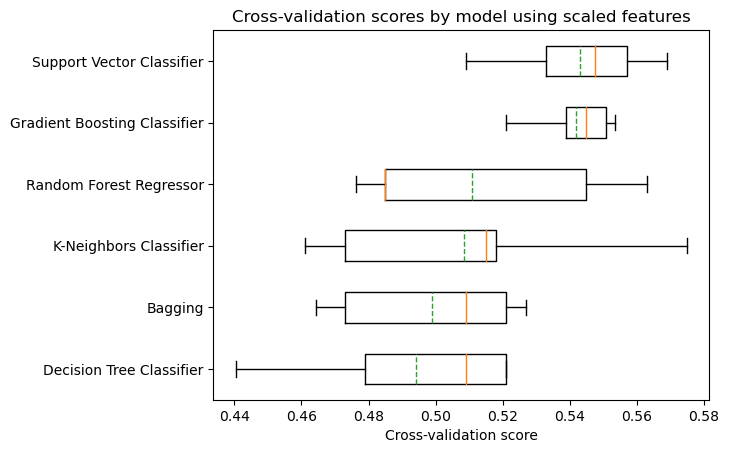

In [22]:
# Testing multiple models using cross validation
np.random.seed(41)
models ={"Random Forest Regressor": RandomForestClassifier(random_state=41), "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=41),
         "Support Vector Classifier": SVC(random_state=41), "K-Neighbors Classifier": KNeighborsClassifier(), 
         "Decision Tree Classifier": DecisionTreeClassifier(random_state=41), "Bagging": BaggingClassifier(random_state=41)}

results = []
for name, model in models.items():
	kf = KFold(n_splits=5, random_state=41, shuffle=True)
	cv_results = cross_val_score(model, X_train_scaled, y_train_age, cv=kf) 
	results.append(cv_results)
	print("{} Mean Cross-Validation Accuracy Score: {}".format(name, cv_results.mean()))
    
# Sort the models by the mean cross-validation accuracy score
sorted_results = sorted(zip(models.keys(), results), key=lambda x: x[1].mean(), reverse=False)
labels = [model[0] for model in sorted_results]
results = [model[1] for model in sorted_results]

plt.boxplot(results, labels=labels, meanline=True, showmeans=True, vert=False)
plt.title('Cross-validation scores by model using scaled features')
plt.xlabel('Cross-validation score')
plt.show()

It looks like none of my models are particularly accurate. Gradient Boosting Classifier creates the best model, at an accuracy score of just 54.19%. Let's take a look at the accuracy scores and confusion matrices for the test set.

RandomForestClassifier(random_state=41) Accuracy Score on Test Set: 0.5523809523809524


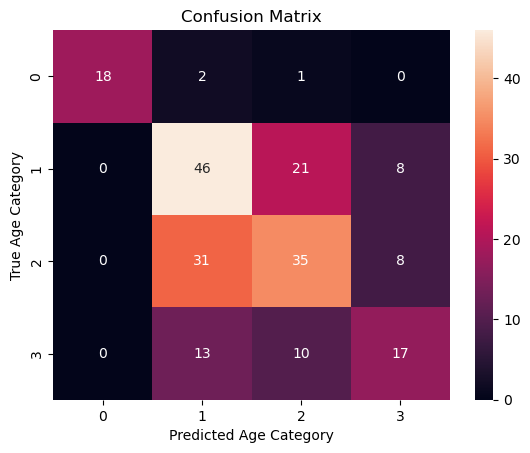

GradientBoostingClassifier(random_state=41) Accuracy Score on Test Set: 0.5714285714285714


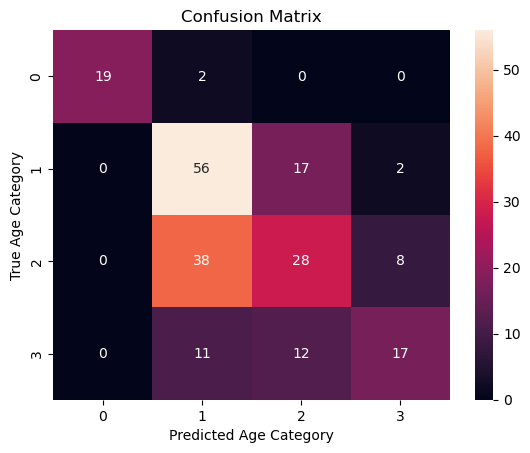

SVC(random_state=41) Accuracy Score on Test Set: 0.6


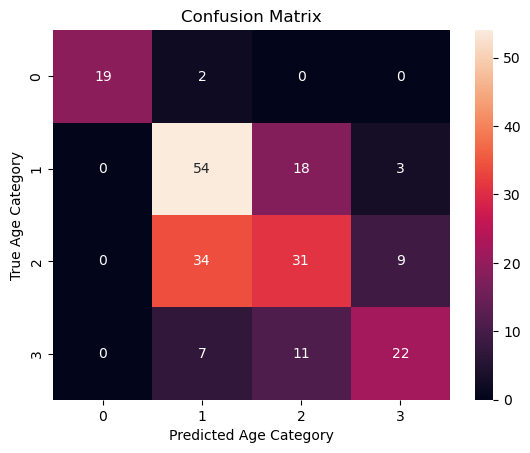

KNeighborsClassifier() Accuracy Score on Test Set: 0.47619047619047616


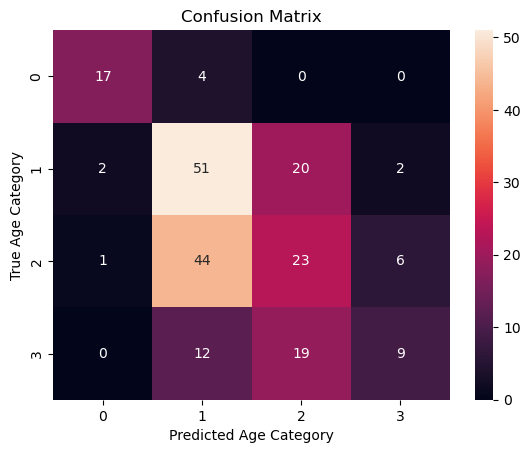

DecisionTreeClassifier(random_state=41) Accuracy Score on Test Set: 0.5190476190476191


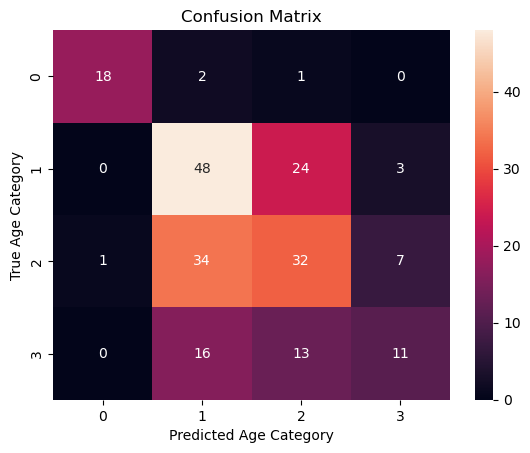

BaggingClassifier(random_state=41) Accuracy Score on Test Set: 0.5285714285714286


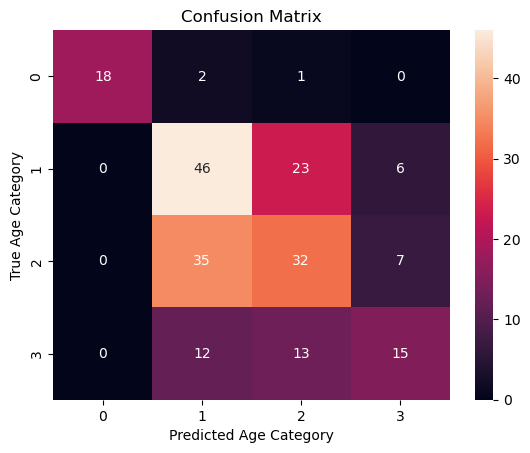

In [23]:
# Testing multiple models on test set, visualizing predictions
results = []
for model in models.values():
    # Fit model on training data, predict test set accuracy
	model.fit(X_train_scaled, y_train_age)
	y_pred_age = model.predict(X_test_scaled)
	accuracy_score = model.score(X_test_scaled, y_test_age)
	print("{} Accuracy Score on Test Set: {}".format(model, accuracy_score))
    
    # Plotting confusion matrix
	cm = confusion_matrix(y_test_age, y_pred_age)
	sns.heatmap(cm, annot=True, fmt='d')
	plt.title('Confusion Matrix')
	plt.xlabel('Predicted Age Category')
	plt.ylabel('True Age Category')
	plt.show()

Even though the accuracy scores for the models are not very impressive, the models do seem to be pretty good at predicting age categories for children ('Age_cat' == 0) and teenagers ('Age_cat' ==1). For example, in the Gradient Boosting Classifier model, the model correctly predicted 19 children out of 21 in the test set 90.48%), and 56 out of 76 teenagers in the test set (73.68%). Note that before, we saw how children have the highest survival rate, while teenagers have the lowest. Given the model's accuracy for the most important age categories, I will impute missing values using the Gradient Boosting Classifier model, which has the best mean cross-validation accuracy score. 

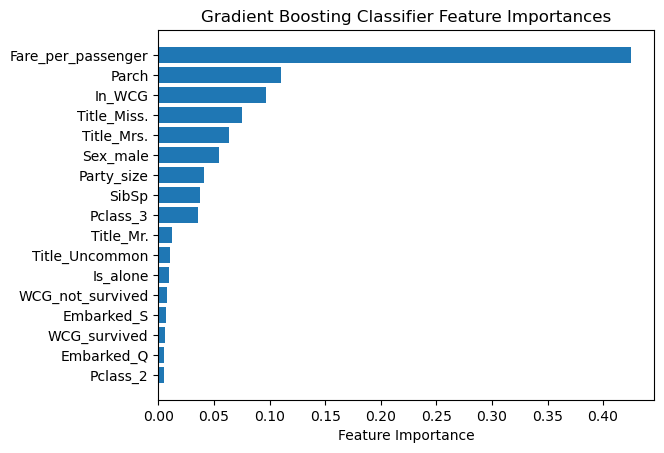

In [24]:
# Fitting GBC on training data
gbc = GradientBoostingClassifier()
gbc.fit(X_train_scaled, y_train_age)

# Extracting and plotting feature importances
feature_importances = gbc.feature_importances_
feature_names = np.array(['Fare_per_passenger', 'SibSp', 'Parch',  
       'In_WCG','WCG_not_survived', 'WCG_survived', 'Party_size', 
       'Is_alone', 'Title_Miss.', 'Title_Mr.', 
       'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S'])

# Sort coefficients in descending order
sort_index = np.argsort(feature_importances)
sorted_coefs = feature_importances[sort_index]
sorted_feature_names = feature_names[sort_index]

plt.barh(sorted_feature_names, sorted_coefs)
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Classifier Feature Importances')
plt.show()

Above, I have plotted the feature importances for the Gradient Boosting Classifier model. Note that this graph does not specify the direction of the relationship between a feature and the outcome variable, 'Age_cat'; only the relative importance. It looks like the most important features in predicting age category are 'Fare_per_passenger', 'Parch', and 'In_WCG'.

In [25]:
# Preparing to impute missing age categories
X_train_cat_age_final = X.loc[:, [
       'SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]
X_test_cat_age_final = test_age.loc[:, [
       'SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S']]

X_train_num_age_final  = X.loc[:, ['Fare_per_passenger']]
X_test_num_age_final = test_age.loc[:, ['Fare_per_passenger']]

scaler = StandardScaler()

X_train_num_age_scaled_final = scaler.fit_transform(X_train_num_age_final)
X_test_num_age_scaled_final = scaler.transform(X_test_num_age_final)

# Concatenate scaled numerical and categorical columns
X_train_scaled_final = np.concatenate([X_train_num_age_scaled_final, X_train_num_age_final], axis=1)
X_test_scaled_final = np.concatenate([X_test_num_age_scaled_final, X_test_num_age_final], axis=1)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


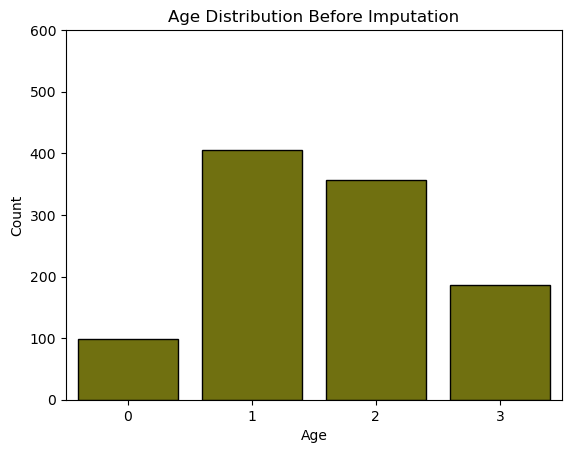

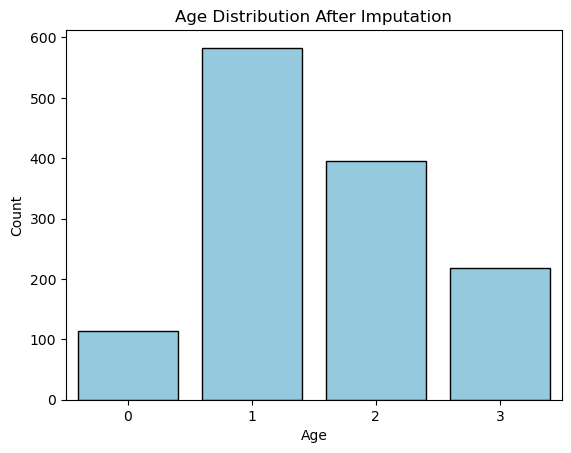

,Pclass,PassengerId,Survived,Age,SibSp,Parch,In_WCG,WCG_not_survived,WCG_survived,Family_size,...,Age_cat,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Uncommon,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
count,1309.000000,1309.000000,891.000000,1046.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,...,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,655.000000,0.383838,29.881138,0.498854,0.385027,0.200917,0.072574,0.128342,1.883881,...,1.548510,0.201681,0.578304,0.151261,0.022154,0.644003,0.211612,0.541635,0.093965,0.699771
std,0.837836,378.020061,0.486592,14.413493,1.041658,0.865560,0.400839,0.259536,0.334598,1.583639,...,0.868304,0.401408,0.494019,0.358440,0.147242,0.478997,0.408607,0.498454,0.291891,0.458533
min,1.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,328.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,655.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,3.000000,982.000000,1.000000,39.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,1309.000000,1.000000,80.000000,8.000000,9.000000,1.000000,1.000000,1.000000,11.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_scaled_final, y)
y_pred_age = gbc.predict(X_test_scaled_final)
test_age.loc[:, 'Age_cat'] = y_pred_age

# Creating full dataframe with no missing values for 'Age_cat' 
combined_cleaned = pd.concat([train_age, test_age], axis=0)

# Checking distribution of age categories before and after imputing
distribution_before = train_age['Age_cat'].value_counts()
sns.barplot(x=distribution_before.index, y=distribution_before.values, alpha=1, label='Before', color='olive', edgecolor='black', order=[0,1,2,3])
plt.title('Age Distribution Before Imputation')
plt.xlabel('Age')
plt.ylabel('Count')
plt.yticks(ticks=np.arange(0,700,100))
plt.show()

distribution_after = combined_cleaned['Age_cat'].value_counts()
sns.barplot(x=distribution_after.index, y=distribution_after.values, alpha=1, label='After', edgecolor='black', color='skyblue', order=[0,1,2,3])
plt.title('Age Distribution After Imputation')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
display(combined_cleaned.describe())

It looks like the age distributions before and after imputing are slightly different, which is expected based on the low accuracy of the model. Our GBC model tends to predict a lot of teenagers ('Age_cat' == 1) and adults ('Age_cat' == 2) so there is a jump in these categories.

Now I have dealt with all of the missing values in the dataset. I will now move on to visualizing some of the relationships between variables and see if we can learn anything interesting about those who survived the sinking of *The Titanic*. 

# 4. Data Visualization <a class="anchor"  id="chapter4"></a>

Before I build out my models, I think it will be helpful to visualize the features in the training dataset and their relationships to passenger survival. What story is the data telling about who was rescued and who was not?

In [27]:
# Split combined dataset back into training and test sets based on 'Survived' missingness
train_original = combined_cleaned[(combined_cleaned['Survived']==1) | (combined_cleaned['Survived']==0)]
test_original = combined_cleaned[combined_cleaned['Survived'].isna()]

### How are the categorical features correlated with survival?

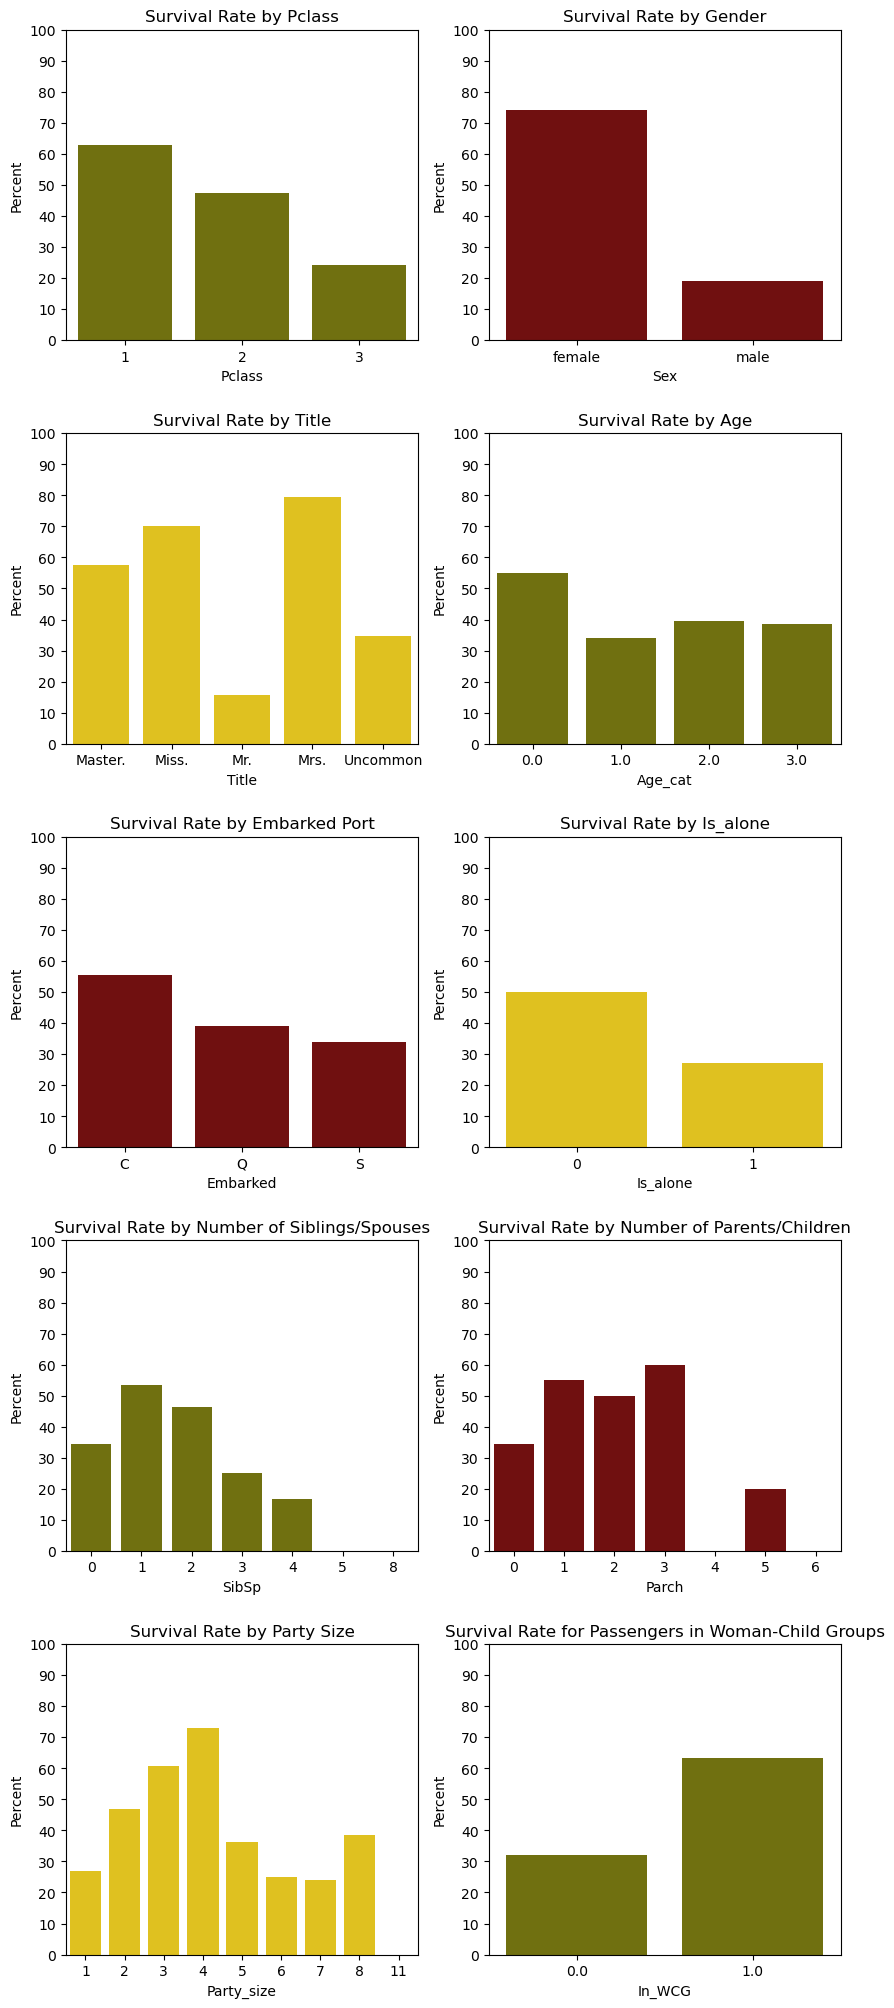

In [28]:
def plot_survival_rate(data, x_col, y_col, title, color, ax):
    survival_rate = data.groupby(x_col)[y_col].value_counts(normalize=True).unstack()
    survival_rate = survival_rate[1]
    sns.barplot(x=survival_rate.index, y=survival_rate.values, color=color, ax=ax)
    ax.set_title(title)
    ax.set_yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
    ax.set_ylabel('Percent')

fig, axs = plt.subplots(5,2,figsize=(10,25))

plot_survival_rate(train_original, 'Pclass', 'Survived', 'Survival Rate by Pclass', 'olive', axs[0,0])
plot_survival_rate(train_original, 'Sex', 'Survived', 'Survival Rate by Gender', 'maroon', axs[0,1])
plot_survival_rate(train_original, 'Title', 'Survived', 'Survival Rate by Title', 'gold', axs[1,0])
plot_survival_rate(train_original, 'Age_cat', 'Survived', 'Survival Rate by Age', 'olive', axs[1,1])
plot_survival_rate(train_original, 'Embarked', 'Survived', 'Survival Rate by Embarked Port', 'maroon', axs[2,0])
plot_survival_rate(train_original, 'Is_alone', 'Survived', 'Survival Rate by Is_alone', 'gold', axs[2,1])
plot_survival_rate(train_original, 'SibSp', 'Survived', 'Survival Rate by Number of Siblings/Spouses', 'olive', axs[3,0])
plot_survival_rate(train_original, 'Parch', 'Survived', 'Survival Rate by Number of Parents/Children', 'maroon', axs[3,1])
plot_survival_rate(train_original, 'Party_size', 'Survived', 'Survival Rate by Party Size', 'gold', axs[4,0])
plot_survival_rate(train_original, 'In_WCG', 'Survived', 'Survival Rate for Passengers in Woman-Child Groups', 'olive', axs[4,1])

plt.subplots_adjust(hspace=0.3)
plt.show()


If you were a male passenger traveling alone in third class, between the ages of 14 and 28, and embarked from Southhampton... it looks like your chances were pretty dismal. 

On the other hand, if you were a young girl traveling with others in first class, and embarked from Cherbourg, you may have turned out alright. 

It looks like passengers were more likely to get rescued as their party size increased, but after there were 4 passengers in a group, the effect faded disappeared quickly. As women and children had higher survival rates, it would make sense that those in Woman-Child-Groups would have higher survival rates as well.

Were people who embarked from Cherbourg just lucky? Maybe there's something else at play here to explain the difference in survival rates between ports.

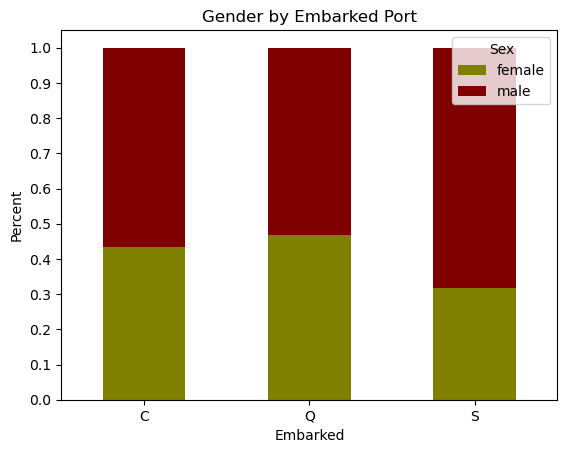

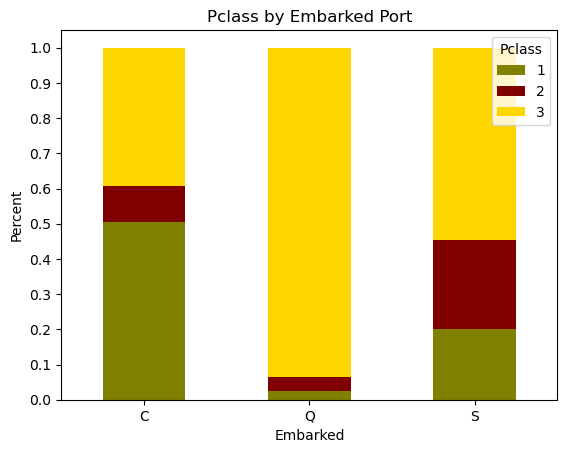

In [29]:
train_original.groupby('Embarked')['Sex'].value_counts(normalize=True).unstack().plot.bar(stacked=True, color=['olive', 'maroon'])
plt.title('Gender by Embarked Port')
plt.ylabel('Percent')
plt.xticks(rotation=360)
plt.yticks(ticks=np.arange(0,1.1,0.1))
plt.show()

train_original.groupby('Embarked')['Pclass'].value_counts(normalize=True).unstack().plot.bar(stacked=True, color=['olive', 'maroon', 'gold'])
plt.title('Pclass by Embarked Port')
plt.ylabel('Percent')
plt.xticks(rotation=360)
plt.yticks(ticks=np.arange(0,1.1,0.1))
plt.show()


It looks like those who embarked from Cherbourg were more likely to fall into the first passenger class, which could explain their increased survival rate compared to passengers who embarked from Queenstown or Southampton.

### How is passenger fare correlated with survival?

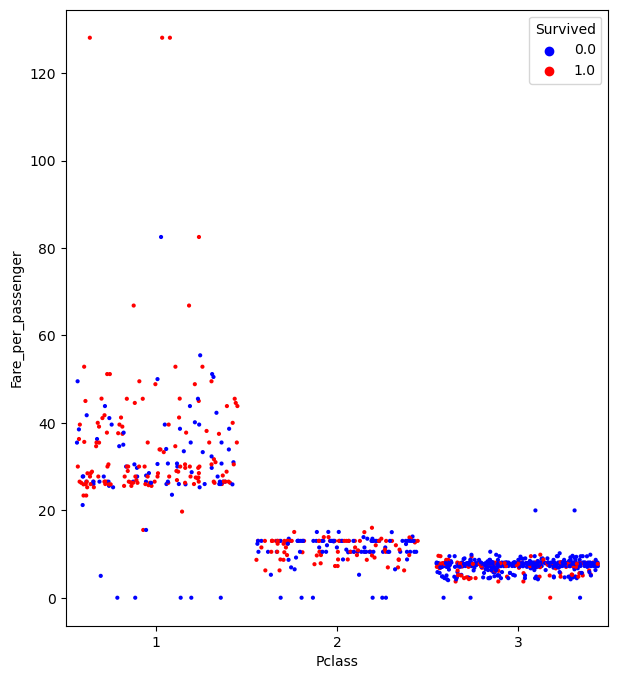

In [30]:
fig, axs = plt.subplots(figsize=(7,8))
sns.stripplot(x='Pclass', y='Fare_per_passenger', hue='Survived', data=train_original, jitter=0.45, size=3, palette=['blue', 'red'])
plt.show()

As we can see in the above plot, passenger fare is split up by class, which is expected. In addition, it looks like those who paid more were also more likely to be rescued. Women & children first, and then first class passengers!

Now that I have a good idea of the story the data is telling, I will build some models to help us predict the survival of the passengers in the test set.

# 5. Building a Model to Predict Survival <a class="anchor"  id="chapter5"></a>

Below, I will try a few different models that are appropriate for predicting binary outcomes. Note that I am splitting the original training set (which contains no missing values for 'Survival') into a further training and test set so that I can test the accuracy of the model before submitting my predictions. 

Models:
- Logistic Regression:  a statistical model that is commonly used to predict binary outcomes, assumes a linear relationship between the input variables and the log-odds of the outcome
- Random Forest Classifier: an ensemble learning model that combines multiple decision trees to create a more accurate model, randomly selects a subset of features for each tree to prevent overfitting and improve accuracy
- K-Nearest Neighbors: predicts categorical outcome by based on k-closest neighbors in the training set 
- Support Vector Machines (SVMs): a model that finds the best hyperplane to separate the data into different classes, and then predicts the target variable based on the position of the test point relative to the hyperplane
- Naive Bayes: a probabilistic classification algorithm based on Bayes' theorem, assumes that the input variables are normally distributed and independent 
- Gradient Boosting Classifier: ensemble model that combines multiple weak learners, normally decision trees, to create a strong learned for classification problems 
- Decision Tree Classifier: tree-like model that splits data based on the feature that maximizes information gain or reduces impurity at each node 
- Bagging Classifier: Boostrap aggregation method that uses one algorithm on different subsets of the training set

I will test the cross-validation scores for each model using default parameters. From there, I will take the best models of the bunch and do some more hyperparameter tuning to see if I can improve their performance further. 

## 5.1 Testing Multiple Models <a class="anchor"  id="section_5_1"></a>

In [31]:
display(combined_cleaned.columns)

Index(['Title', 'Sex', 'Pclass', 'Embarked', 'PassengerId', 'Survived', 'Age',
       'SibSp', 'Parch', 'In_WCG', 'WCG_not_survived', 'WCG_survived',
       'Family_size', 'Ticket_group_size', 'Party_size', 'Is_alone',
       'Fare_per_passenger', 'Age_cat', 'Title_Miss.', 'Title_Mr.',
       'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2', 'Pclass_3',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [32]:
# Importing additional libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Splitting combined_cleaned data set back into original train and test sets
train_original['Survived'] = train_original['Survived'].astype(int)

# Splitting training data into features and outcome variable
X = train_original[[
       'SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Fare_per_passenger', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Age_cat']]
y = train_original[['Survived']].values.ravel()

# Splitting training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Scaling the Fare_per_passenger to create scaled training and test sets
scaler = StandardScaler()

X_train_num = X_train.loc[:, ['Fare_per_passenger']]
X_test_num = X_test.loc[:, ['Fare_per_passenger']]

X_train_cat = X_train.loc[:, ['SibSp', 'Parch','In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone',  'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Age_cat']]
X_test_cat = X_test.loc[:, ['SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Age_cat']]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Concatenate scaled numerical and categorical columns
X_train_scaled = np.concatenate([X_train_num_scaled, X_train_cat], axis=1)
X_test_scaled = np.concatenate([X_test_num_scaled, X_test_cat], axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now I will test multiple models on the test set and also using K-fold cross validation. This will give me a quick idea of how I can expect each model to perform on new, unseen data.

Logistic Regression Mean Cross-Validation Accuracy Score: 0.8496995961784695
Random Forest Classifier Mean Cross-Validation Accuracy Score: 0.8413276863981091
KNN Mean Cross-Validation Accuracy Score: 0.8356446370530879
Support Vector Classifier Mean Cross-Validation Accuracy Score: 0.8581404510981976
Naive Bayes Mean Cross-Validation Accuracy Score: 0.8553432483009947
Gradient Boosting Mean Cross-Validation Accuracy Score: 0.863774253915099
Decision Tree Classifer Mean Cross-Validation Accuracy Score: 0.8328671328671329
Bagging Mean Cross-Validation Accuracy Score: 0.8567418496995961


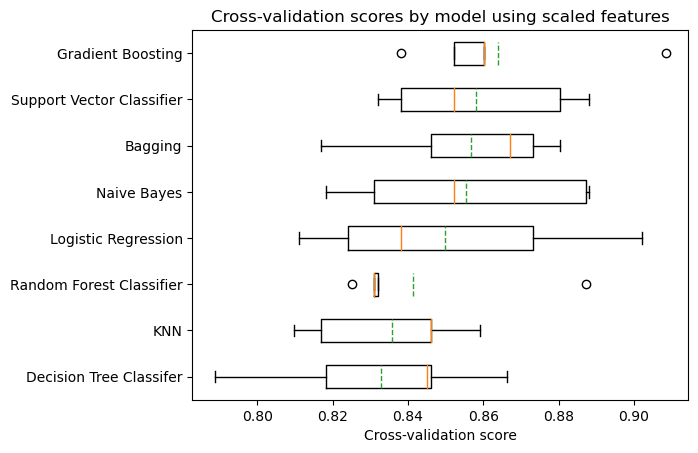

Logistic Regression Test Set Accuracy: 0.8603351955307262
Random Forest Classifier Test Set Accuracy: 0.8435754189944135
KNN Test Set Accuracy: 0.8491620111731844
Support Vector Classifier Test Set Accuracy: 0.8603351955307262
Naive Bayes Test Set Accuracy: 0.8659217877094972
Gradient Boosting Test Set Accuracy: 0.8659217877094972
Decision Tree Classifer Test Set Accuracy: 0.8659217877094972
Bagging Test Set Accuracy: 0.8603351955307262


In [33]:
# Testing multiple models on scaled features
np.random.seed(41)
models ={"Logistic Regression": LogisticRegression(max_iter=2000, random_state=41), "Random Forest Classifier": RandomForestClassifier(random_state=41), 
         "KNN": KNeighborsClassifier(), "Support Vector Classifier": SVC(random_state=41), "Naive Bayes": GaussianNB(), 
         "Gradient Boosting": GradientBoostingClassifier(random_state=41), "Decision Tree Classifer": DecisionTreeClassifier(random_state=41), 
         "Bagging": BaggingClassifier(random_state=41)}
results = []
for name, model in models.items():
	kf = KFold(n_splits=5, random_state=41, shuffle=True)
	cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf) 
	results.append(cv_results)
	print("{} Mean Cross-Validation Accuracy Score: {}".format(name, cv_results.mean()))
    
# Sort the models by the mean cross-validation accuracy score
sorted_results = sorted(zip(models.keys(), results), key=lambda x: x[1].mean(), reverse=False)
labels = [model[0] for model in sorted_results]
results = [model[1] for model in sorted_results]

plt.boxplot(results, labels=labels, meanline=True, showmeans=True, vert=False)
plt.title('Cross-validation scores by model using scaled features')
plt.xlabel('Cross-validation score')
plt.show()

# Model performance on test set
for name, model in models.items(): 
	model.fit(X_train_scaled, y_train)
	test_score = model.score(X_test_scaled, y_test)
	print("{} Test Set Accuracy: {}".format(name, test_score))

Above, I tested the accuracy of each model using default features. The one exception is that I increased the max iterations for the Logistic Regression model from 1000 to 2000 as it failed to converge otherwise. 

On the test set, the best performing models were Bagging Classifier, Gradient Boosting Classifier, and Naive Bayes, all with accuracies of 86.59%. 

I also found the cross-validation scores for each model using K-Fold cross validation to estimate how each model could be expected to perform on new, unseen data. The models with the best CV accuracy scores are **Gradient Boosting** with a mean CV score of 86.38% and **Support Vector Classifier** with a mean CV score of 85.81%.

I will take these two best models in terms of cross-validation scores and tune their hyperparameters to see if I can further increase their accuracy. 

## 5.2 Gradient Boosting <a class="anchor"  id="section_5_2"></a>

Gradboost accuracy on test set with default params: 0.8659217877094972
Gradboost mean CV score with default params: 0.863774253915099
Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'learning_rate': 0.1, 'max_depth': 6, 'max_leaf_nodes': 7, 'n_estimators': 100}
Gradboost accuracy on test set with best params: 0.8715083798882681
Gradboost mean CV score using best hyperparameters: 0.8735743130109327


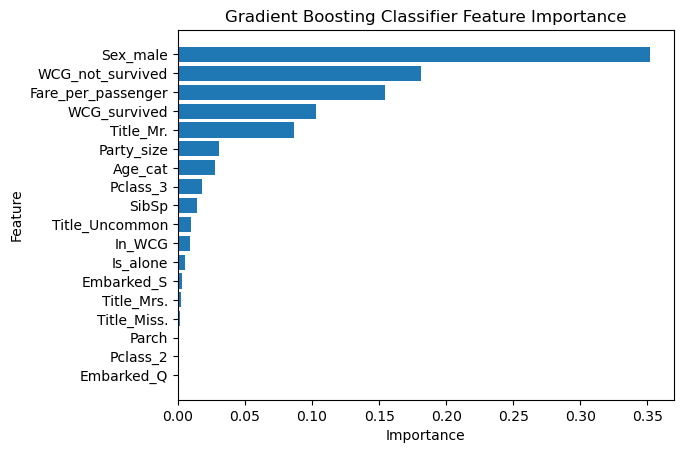

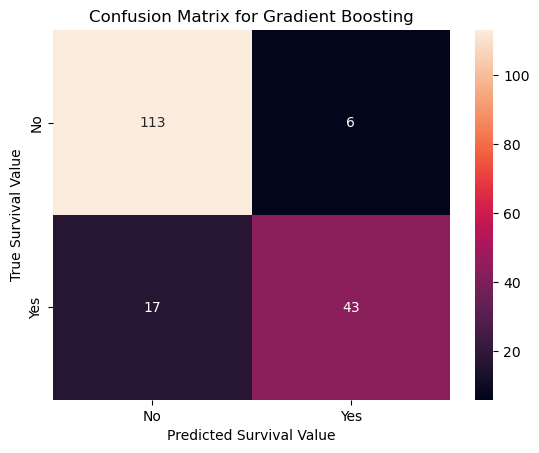

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       119
           1       0.88      0.72      0.79        60

    accuracy                           0.87       179
   macro avg       0.87      0.83      0.85       179
weighted avg       0.87      0.87      0.87       179



In [34]:
# Checks gradient boosting regression accuracy on test set using default model parameters
gradboost = GradientBoostingClassifier(random_state=41)
model = gradboost.fit(X_train_scaled, y_train)
gradboost_score = gradboost.score(X_test_scaled, y_test)
print("Gradboost accuracy on test set with default params:", gradboost_score)

np.random.seed(41)
# Cross validation score 
# Estimates how default gradient boosting regression model would perform on new, unseen data
kf = KFold(n_splits=5, shuffle=True, random_state=41)
cv_results = cross_val_score(gradboost, X_train_scaled, y_train, cv=kf)
print("Gradboost mean CV score with default params:", cv_results.mean())

# Checking best hyperparameters for gradient boosting model
# Note that I tried numerous values below, but am only including a few to keep this section from getting too computationally expensive

gradboost_params = {
    "n_estimators": [75, 100, 150],
    "max_leaf_nodes": [6, 7, 8],
    "learning_rate": [0.05, 0.1, 0.15],
    "max_depth": [5, 6, 7]
}
gradboost_cv = GridSearchCV(gradboost, gradboost_params, cv=kf, verbose=1, n_jobs=-1)
gradboost_cv.fit(X_train_scaled, y_train)
print(gradboost_cv.best_params_)

# Fit gradient boosting regression model with best hyperparameters found through GridSearchCV
gradboost_best = GradientBoostingClassifier(n_estimators=100, max_leaf_nodes=7,
                                            learning_rate=0.1, max_depth=6, random_state=41)
gradboost_best.fit(X_train_scaled, y_train)
y_pred = gradboost_best.predict(X_test_scaled)
gradboost_score = gradboost_best.score(X_test_scaled, y_test)
cv_results_best = cross_val_score(gradboost_best, X_train_scaled, y_train, cv=kf)          
print("Gradboost accuracy on test set with best params: {}".format(gradboost_score))     
print("Gradboost mean CV score using best hyperparameters: {}".format(cv_results_best.mean()))

feature_names = np.array(['Fare_per_passenger', 'SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone',  'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Age_cat'])

# Plotting feature importances
importances = gradboost_best.feature_importances_
sort_index = np.argsort(importances)
sorted_importances = importances[sort_index]
sorted_feature_names = feature_names[sort_index]
plt.barh(sorted_feature_names, sorted_importances)
plt.title('Gradient Boosting Classifier Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Create confusion matrix
gradboost_cm = confusion_matrix(y_test, y_pred)

# Create heatmap plot of confusion matrix
sns.heatmap(gradboost_cm, annot=True, fmt='d', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted Survival Value')
plt.ylabel('True Survival Value')
plt.show()

# Create classification report
gradboost_report=classification_report(y_test, y_pred)
print(gradboost_report)

Above I have tested the Gradient Boosting Classifier model on the scaled data using default parameters and adjusted parameters.

As we saw before, the Gradient Boosting model with default parameters is already 86.59% accurate at predicting survival in the test set, and has a cross-validation accuracy score of 86.38%. 

I tested for the best hyperparameters for the model using GridSearchCV, and found that they are n_estimators=100, max_leaf_nodes=7, learning_rate=0.1, and max_depth=6. After updating the hyperparameters, the model is now 87.15% accurate at predicting survival in the test set, and the cross-validation accuracy score has gone up to 87.36%. This means that the model should be about 87.35% accurate at predicting survival in a new, unseen dataset.

I also created a feature importance plot and confusion matrix. The feature importance plot tells us what features the model finds most important when predicting the survival of a passenger. In this plot, the importance is measured as an absolute value, and thus the plot does not reflect the direction of the relationship, just the strength. For example, 'Sex_male' is the most important feature in predicting survival, but this plot does not tell us whether those who are male are more or less likely to survive. 

The confusion matrix breaks down the model's predicted outcomes versus the actual outcomes in the test set. We can see that there are 17 instances where the model incorrectly predicted that the passenger would not survive when they did, and 6 instances where the model incorrectly predicted that the passenger would survive when they didn't. 

Finally, the classification report breaks down some more information regarding the tuned model's predictions.
- The precision for the "0" class is 0.87, which means that when the model predicted a passenger  died, it was correct 87% of the time. Similarly, the precision for the "1" class is 0.88, which means that when the model predicted a passenger survived, it was correct 88% of the time.
- The recall for the "0" class is 0.95, which means that out of all the true passenger deaths in the test set, the model correctly identified 95% of them. Similarly, the recall for the "1" class is 0.72, which means that out of all the true passenger survivals in the test set, the model correctly identified 72% of them.
- F1 score is the harmonic mean of the precision and recall of a model. The F1 score for the "0" class is 0.91, while the F1 score for the "1" class is 0.79. These scores provide an indication of the model's overall performance for each class, taking into account both precision and recall.

## 5.3 Support Vector Classifier <a class="anchor"  id="section_5_3"></a>

SVC accuracy on test set with default params: 0.8603351955307262
SVC mean CV score with default params: 0.8581404510981976
Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
SVC accuracy on test set with best params: 0.8603351955307262
SVC mean CV score using best hyperparameters: 0.8637644046094749


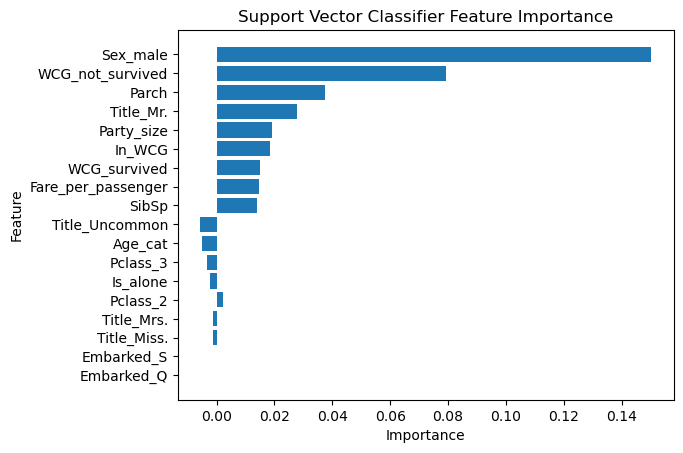

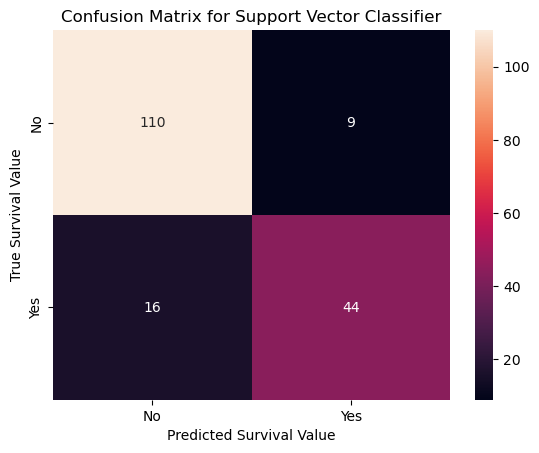

              precision    recall  f1-score   support

           0       0.87      0.92      0.90       119
           1       0.83      0.73      0.78        60

    accuracy                           0.86       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.86      0.86      0.86       179



In [35]:
# Checks SVC boosting regression accuracy on test set using default model parameters
svc = SVC(random_state=41)
model = svc.fit(X_train_scaled, y_train)
svc_score = svc.score(X_test_scaled, y_test)
print("SVC accuracy on test set with default params:", svc_score)

np.random.seed(41)
# Cross validation score 
# Estimates how default SVC regression model would perform on new, unseen data
kf = KFold(n_splits=5, shuffle=True, random_state=41)
cv_results = cross_val_score(svc, X_train_scaled, y_train, cv=kf)
print("SVC mean CV score with default params:", cv_results.mean())

# Checking best hyperparameters for SVC model
# Note that I tried numerous values below, but am only including a few to keep this section from getting too computationally expensive

svc_params = {
    "gamma": [0.0001, 0.01, 0.1, 1],
    "C": [0.1, 1, 10],
    "degree": [2, 3, 4],
    "kernel": ['poly', 'linear', 'sigmoid', 'rbf'] 
}
svc_cv = GridSearchCV(svc, svc_params, cv=kf, verbose=1, n_jobs=-1)
svc_cv.fit(X_train_scaled, y_train)
print(svc_cv.best_params_)

# Fit SVC model with best hyperparameters found through GridSearchCV
svc_best = SVC(gamma=0.1, C=1, degree=2, kernel='poly')
svc_best.fit(X_train_scaled, y_train)
y_pred = svc_best.predict(X_test_scaled)
svc_score = svc_best.score(X_test_scaled, y_test)
cv_results_best = cross_val_score(svc_best, X_train_scaled, y_train, cv=kf)         
print("SVC accuracy on test set with best params: {}".format(svc_score))     
print("SVC mean CV score using best hyperparameters: {}".format(cv_results_best.mean()))

# Calculate permutation feature importances
result = permutation_importance(svc_best, X_test_scaled, y_test, n_repeats=10, random_state=41)

# Extract feature importances and their indices
importances = result.importances_mean
indices = np.argsort(np.abs(importances))

# Plot feature importances
plt.barh(range(X_test_scaled.shape[1]), importances[indices])
plt.yticks(range(X_test_scaled.shape[1]), feature_names[indices])
plt.title('Support Vector Classifier Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Create confusion matrix
svc_cm = confusion_matrix(y_test, y_pred)

# Create heatmap plot of confusion matrix
sns.heatmap(svc_cm, annot=True, fmt='d', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix for Support Vector Classifier')
plt.xlabel('Predicted Survival Value')
plt.ylabel('True Survival Value')
plt.show()

# Create classification report
svc_report=classification_report(y_test, y_pred)
print(svc_report)

Above I have tested the Support Vector Classifier model on the scaled data using default parameters and adjusted parameters.

As we saw before, the SVC model with default parameters is 86.03% accurate at predicting survival in the test set, and has a cross-validation accuracy score of 85.81%. 

I tested for the best hyperparameters for the model, and found that they are C = 1, degree = 2, gamma = 0.1, and kernel = 'poly'. After updating the hyperparameters, the model is still 86.03% accurate at predicting survival in the test set, but the cross-validation accuracy score has gone up to 86.38%. This means that the model should be about 86.38% accurate at predicting survival in a new, unseen dataset.

I also created a feature importance plot using permutation_importance, as SVC does not normally give feature importances unless the kernel is linear, which in this case, it is not. The feature importance plot tells us what features the model finds most important when predicting the survival of a passenger. When using permutation feature importance, negative values normally indicate that a feature is not informative or impactful to a model's performance. We can see that the most impactful features for this model were 'Sex_male', 'WCG_not_survived', and 'Parch'. 

The confusion matrix breaks down the model's predicted outcomes versus the actual outcomes in the test set. We can see that there are 16 instances where the model incorrectly predicted that the passenger would not survive when they did, and 9 instances where the model incorrectly predicted that the passenger would survive when they didn't. 

Finally, the classification report breaks down some more information regarding the tuned model's predictions.

* The precision for the "0" class is 0.87, which means that when the model predicted a passenger died, it was correct 87% of the time. Similarly, the precision for the "1" class is 0.83, which means that when the model predicted a passenger survived, it was correct 83% of the time.
* The recall for the "0" class is 0.92, which means that out of all the true passenger deaths in the test set, the model correctly identified 92% of them. Similarly, the recall for the "1" class is 0.73, which means that out of all the true passenger survivals in the test set, the model correctly identified 73% of them.
* F1 score is the harmonic mean of the precision and recall of a model. The F1 score for the "0" class is 0.90, while the F1 score for the "1" class is 0.78. These scores provide an indication of the model's overall performance for each class, taking into account both precision and recall.

# 6. Final Predictions <a class="anchor"  id="chapter6"></a>

The Gradient Boosting Classifier model with tuned hyperparameters appears to have the best mean cross-validation score, although the tuned SVC model is behind by less than a percentage point. I tested all four models - Gradient Boosting with default parameters, Gradient Boosting with tuned hyperparameters, SVC with default parameters, and SVC with tuned hyperparameters - on the public leaderboard and found that SVC with default parameters actually resulted in the best score for the final prediction test set, at 81.33%. 

There are a few reasons why the SVC model with default parameters may have turned out better than the others. The first and most obvious is that the models are overfitting the training data. This has been apparent throughout the trial and error on this dataset, as I have consistently found cross-validation scores and test set accuracy to be ~5% higher than the public leaderboard score. It could also be the case that the prediction test set is fundamentally different from the training set in terms of its features, leading to a mismatch between the training accuracy and final prediction accuracy. Finally, machine learning models are inherently random, and the performance of a model can vary from one test set to another. It could be the case that SVC does have a worse CV score than Gradient Boosting, but it just happened to perform better on the one test set that is scored on the public leaderboard. 

No matter what the reason, I was able to score 81.33%, which is top 2% on the leaderboard as of the time of my submission. Not too shabby!

Happy Kaggling :) 

In [36]:
# Preparing dataset for final predictions
X_train = train_original[[
       'SibSp', 'Parch',  'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Fare_per_passenger', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Age_cat']]
y_train = train_original[['Survived']].values.ravel()
X_test = test_original[['SibSp', 'Parch',  'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Fare_per_passenger', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Age_cat']]

# Scaling the Fare_per_passenger column to create scaled training and test sets
scaler = StandardScaler()

X_train_num = X_train.loc[:, ['Fare_per_passenger']]
X_test_num = X_test.loc[:, ['Fare_per_passenger']]

X_train_cat = X_train.loc[:, ['SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone',  'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Age_cat']]
X_test_cat = X_test.loc[:, ['SibSp', 'Parch', 'In_WCG',
       'WCG_not_survived', 'WCG_survived', 
       'Party_size', 'Is_alone', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Uncommon', 'Sex_male', 'Pclass_2',
       'Pclass_3', 'Embarked_Q', 'Embarked_S', 'Age_cat']]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Concatenate scaled numerical and categorical columns
X_train_scaled = np.concatenate([X_train_num_scaled, X_train_cat], axis=1)
X_test_scaled = np.concatenate([X_test_num_scaled, X_test_cat], axis=1)

In [37]:
best_model = SVC(random_state=41)
best_model.fit(X_train_scaled, y_train)
final_prediction = best_model.predict(X_test_scaled)

submission = pd.DataFrame({
        "PassengerId": test_original["PassengerId"],
        "Survived": final_prediction
    })
display(submission['Survived'].value_counts())
display(submission.dtypes)

0    274
1    144
Name: Survived, dtype: int64

PassengerId    int64
Survived       int64
dtype: object

In [38]:
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('submission.csv', index=False)